In [ ]:
import os
import json
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoProcessor,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)

from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from transformers import LlavaNextVideoProcessor, LlavaNextVideoForConditionalGeneration
from utils import check_model_dtypes

# 数据集路径
BASE_PATH = "/home/jiangyanbo/hf_finetune/example_data"
IMAGE_DIR = os.path.join(BASE_PATH, "images")
TRAIN_JSON = os.path.join(BASE_PATH, "celeba_image_train.json")
EVAL_JSON = os.path.join(BASE_PATH, "celeba_image_eval.json") if os.path.exists(os.path.join(BASE_PATH, "celeba_image_eval.json")) else None

# 模型配置
MODEL_ID = "llava-hf/LLaVA-NeXT-Video-7B-hf"
OUTPUT_DIR = "/home/jiangyanbo/hf_finetune/llava_next_celeba_finetuned"


In [ ]:
# 数据集
cla

In [ ]:
model = LlavaNextVideoForConditionalGeneration.from_pretrained(
    MODEL_ID,
    # quantization_config=bnb_config,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="auto"
)
# check_model_dtypes(model)

# 将模型准备为 PEFT（参数高效微调）
# model = prepare_model_for_kbit_training(model)
# 配置 LoRA
lora_config = LoraConfig(
    r=16,  # LoRA 的秩
    lora_alpha=32,  # LoRA 的缩放参数
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # 打印可训练参数比例
processor = AutoProcessor.from_pretrained(MODEL_ID)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


trainable params: 42,336,256 || all params: 7,105,767,424 || trainable%: 0.5958


In [190]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-4,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    # gradient_accumulation_steps=4,
    save_steps=100,
    logging_steps=10,
    save_total_limit=1,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="tensorboard",
    # load_best_model_at_end=True if eval_dataset else False,
)

In [192]:
# 创建自定义数据集
class CelebADataset(Dataset):
    def __init__(self, json_file, processor, max_length=1024):
        self.processor = processor
        self.max_length = max_length
        
        # 加载数据
        with open(json_file, 'r') as f:
            self.data = json.load(f)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(IMAGE_DIR, item["image"])
        
        # 加载并预处理图像
        # image = Image.open(image_path).convert("RGB")
        # 加载并预处理图像
        image = Image.open(image_path).convert("RGB")
        # print(image.size, type(image))
        # 转化为 numpy 数组
        # image_array = np.array(image)
        # print(image_array.shape)
        image_array = np.array(image)
        clip = np.stack([image_array] * 8)
        
        # 提取对话
        human_msg = item["conversations"][0]["value"].replace("<image>", "")
        assistant_msg = item["conversations"][1]["value"]
        
        # 构建对话历史
        conversation = [
            {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": human_msg}]},
            {"role": "assistant", "content": assistant_msg}
        ]
        prompt = self.processor.apply_chat_template(conversation, add_generation_prompt=False)
        # 处理文本和图像
        inputs = self.processor(
            text=prompt,
            images=image, 
            # videos=clip,
            padding=True,
            # truncation=True,
            # max_length=self.max_length,
            return_tensors="pt"
        )
        
        # 移除批量维度
        # for k, v in inputs.items():
        #     inputs[k] = v.squeeze()

        # print(inputs["input_ids"].shape, inputs["attention_mask"].shape, inputs["images"].shape)
        # print(inputs["pixel_values"].shape)
        # print_item(inputs)
            
        return inputs
    
 # 创建数据集
train_dataset = CelebADataset(TRAIN_JSON, processor)
eval_dataset = CelebADataset(EVAL_JSON, processor) if EVAL_JSON else None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


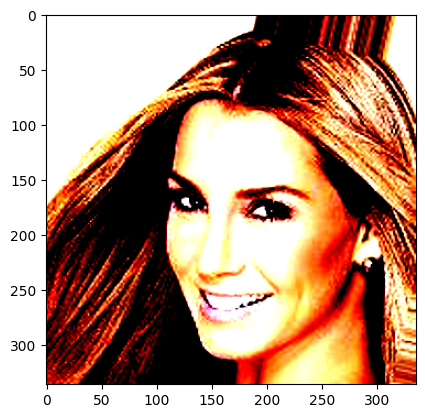

In [103]:
plt.imshow(item.data['pixel_values_videos'].permute(1, 2, 0))
plt.show()

In [178]:
item = train_dataset[2]
# # 能画出这张图吗, 其中第一个维度是3，为rgb
# import matplotlib.pyplot as plt
# plt.imshow(item.data['pixel_values'][0].permute(1, 2, 0))
# plt.show()
# plt.imshow(item.data['pixel_values'][1].permute(1, 2, 0))
# plt.show()
# plt.imshow(item.data['pixel_values'][2].permute(1, 2, 0))
# plt.show()

input_ids  :  torch.Size([1, 1100])
attention_mask  :  torch.Size([1, 1100])
pixel_values  :  torch.Size([1, 3, 3, 336, 336])
image_sizes  :  torch.Size([1, 2])


In [174]:
def print_item(item):
    for key in item.data.keys():
        print(key, " : ",item.data[key].shape)

print_item(item)

input_ids  :  torch.Size([1, 1100])
attention_mask  :  torch.Size([1, 1100])
pixel_values  :  torch.Size([1, 3, 3, 336, 336])
image_sizes  :  torch.Size([1, 2])


In [179]:
# item['input_ids']
output = model.generate(**item, max_new_tokens=100, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=False))

/home/jiangyanbo/miniconda3/envs/deepseek/lib/python3.10/site-packages/transformers/generation/utils.py:2105: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


ER: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><i

In [ ]:
def custom_data_collator(data):
    batch = {
        "input_ids": torch.cat([item["input_ids"] for item in data], dim=0),
        "attention_mask": torch.cat([item["attention_mask"] for item in data], dim=0),
        "labels": torch.cat([item["input_ids"] for item in data], dim=0),
    }
    print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)
    # 处理 pixel_values
    if "pixel_values" in data[0]:
        # 将每个样本的多张图片合并为一个批次
        # pixel_values = [item["pixel_values"] for item in data]
        # 重新排列维度，使其符合 (batch_size, num_images, channels, height, width)
        pixel_values = torch.cat([item["pixel_values"] for item in data], dim=0)
        batch["pixel_values"] = pixel_values
        batch["image_sizes"] = torch.cat([item["image_sizes"] for item in data],dim=0)
        print(batch["pixel_values"].shape)
        print(batch["image_sizes"].shape)
    
    # output = model.generate(**batch, max_new_tokens=100, do_sample=False)
    # print_item(batch)
    
    return batch

# def custom_data_collator(data):
#     batch = {
#         "input_ids": torch.stack([item["input_ids"] for item in data]),
#         "attention_mask": torch.stack([item["attention_mask"] for item in data]),
#         "labels": torch.stack([item["input_ids"] for item in data]),
#     }
    
#     # 处理 pixel_values
#     # if "pixel_values" in data[0]:
#     #     # 将每个样本的多张图片合并为一个批次
#     #     # pixel_values = [item["pixel_values"] for item in data]
#     #     # 重新排列维度，使其符合 (batch_size, num_images, channels, height, width)
#     #     pixel_values = torch.stack([item["pixel_values"] for item in data])
#     #     batch["pixel_values"] = pixel_values
    
#     # # output = model.generate(**batch, max_new_tokens=100, do_sample=False)
#     # print_item(batch)
    
#     return batch

# 创建 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    # data_collator=lambda data: {
    #     "input_ids": torch.stack([item["input_ids"] for item in data]),
    #     "attention_mask": torch.stack([item["attention_mask"] for item in data]),
    #     "labels": torch.stack([item["input_ids"] for item in data]),
    #     # "pixel_values": torch.stack([item["pixel_values"] for item in data]) if "pixel_values" in data[0] else None,
    #     # "pixel_values": torch.stack([item["pixel_values"] for item in data]),
    # },
    data_collator = custom_data_collator,
)

# 开始训练
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


torch.Size([2, 1100]) torch.Size([2, 1100]) torch.Size([2, 1100])
torch.Size([2, 3, 3, 336, 336])
torch.Size([2, 1, 2])
torch.Size([2, 1100]) torch.Size([2, 1100]) torch.Size([2, 1100])
torch.Size([2, 3, 3, 336, 336])
torch.Size([2, 1, 2])


ValueError: not enough values to unpack (expected 2, got 1)